# Stellar SV Fibre Assignment

Set up and run fiber assignment based on the tile files generated by `ssv_areas.ipynb`.

* Create an input target catalog from the sweeps
* Create the Merged Target List
* Run fiber assignment

## Preamble

In [1]:
RUN_NAME = 'ssv_ref'

In [2]:
import os
import sys
import warnings
import subprocess
from   importlib import reload
import json
import glob

import astropy
import astropy.units as u
import astropy.coordinates as coord
from   astropy.io import fits
from   astropy.table import Table, Column

import numpy as np

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane

import fitsio

# Add the python scripts associated with this notebook (under ./py)
add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))


# Run an alternate DESItarget out of code directory
WITH_SSV_DESITARGET   = True
SSV_DESITARGET_PATH   = '/global/homes/a/apcooper/desi/code/desitarget/py/'
SSV_DESITARGET_BRANCH = 'stellar_sv'
if WITH_SSV_DESITARGET:
    add_sys_path.append(SSV_DESITARGET_PATH)

    ssv_desitarget_branch = subprocess.getoutput('pushd {} > /dev/null; git rev-parse --symbolic-full-name --abbrev-ref HEAD; popd > /dev/null'.format(SSV_DESITARGET_PATH))
    assert(ssv_desitarget_branch == SSV_DESITARGET_BRANCH)
    
for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.insert(0,_)

# This is the standard desitarget, we will swap it out later
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
    
import desitarget.io as io
import desitarget.mtl
import desitarget.cuts

import desitarget.sv1.sv1_cuts
import desitarget.sv1.sv1_targetmask
from   desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask, scnd_mask, obsmask

from   desitarget.targetmask import obsconditions

# Local scripts for SSV        
import ssv
from   ssv.plan import Tile, Dither, DitherSet
import ssv.area as sv_area
reload(sv_area)

# Import pyplot last
import matplotlib.pyplot as pl

MWS_TARGET_NAME    = 'MWS_TARGET'
BGS_TARGET_NAME    = 'BGS_TARGET'
DESI_TARGET_NAME   = 'DESI_TARGET'
SCND_TARGET_NAME   = 'SCND_TARGET'

DESITARGET_SURVEY  = 'SV1'
if DESITARGET_SURVEY.startswith('SV'):
    for _ in ['MWS_TARGET_NAME','BGS_TARGET_NAME','DESI_TARGET_NAME','SCND_TARGET_NAME']:
        locals()[_] = '{}_{}'.format(DESITARGET_SURVEY,locals()[_])

# Setup directory environment
ROOT_DIR   = os.getcwd()
GLOBAL_DIR = os.path.join(ROOT_DIR,'global')
TILES_DIR  = os.path.join(GLOBAL_DIR,'tiles')
DATA_DIR   = os.path.join(ROOT_DIR,'data')
RUNS_DIR   = os.path.join(ROOT_DIR,'runs')

for d in ['ROOT_DIR','GLOBAL_DIR','TILES_DIR','DATA_DIR','RUNS_DIR']:
    print('{:10s} = {:s}'.format(d,locals()[d]))

ROOT_DIR   = /global/u1/a/apcooper/projects/ssv_plan
GLOBAL_DIR = /global/u1/a/apcooper/projects/ssv_plan/global
TILES_DIR  = /global/u1/a/apcooper/projects/ssv_plan/global/tiles
DATA_DIR   = /global/u1/a/apcooper/projects/ssv_plan/data
RUNS_DIR   = /global/u1/a/apcooper/projects/ssv_plan/runs


In [3]:
MTL_DIR = os.path.join(RUNS_DIR,RUN_NAME,'mtl')
OUT_DIR = os.path.join(RUNS_DIR,RUN_NAME,'out')

for _ in [MTL_DIR,OUT_DIR]:
    if not os.path.exists(_): os.makedirs(_)   

## Create an input target catalog from the sweeps

This uses `desitarget_cuts` to assign target classes to objects. It doesn't assign priorities etc.; that happens when the MTL is made in the next section.

We define a custom SV target bitmasks and patch `desitarget` to implement cuts that use those.

In [4]:
# Check the target bit definitions
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.sv1.sv1_targetmask.mws_mask.names()

MWS_MAIN_SV
MWS_NEARBY_SV
MWS_MAIN_SV_NORTH
MWS_MAIN_SV_SOUTH
MWS_MAIN_SV_FAINT
MWS_MAIN_SV_FAINT_NORTH
MWS_MAIN_SV_FAINT_SOUTH
MWS_CALIB_BOSS
MWS_CALIB_CLUSTER
MWS_CALIB_VERYBRIGHT
MWS_SPECIAL_RRLYR
MWS_SPECIAL_BHB
MWS_SPECIAL_MP
MWS_SPECIAL_HYADES
MWS_SPECIAL_HYADES_VERYBRIGHT


True

In [5]:
# Read SSV tiles
sweeps_json_path = os.path.join(TILES_DIR,'sweeps.json')
with open(sweeps_json_path,'r') as f:
    sweep_dict = json.load(f)


In [6]:
sweep_index     = list(map(int,sweep_dict.keys()))
sweep_filenames = [sweep_dict[str(i)] for i in sweep_index]

In [7]:
len(sweep_filenames)

39

In [8]:
sweep_filenames

['/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-170p045-180p050.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-250p035-260p040.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-160p045-170p050.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-140p035-150p040.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-240p030-250p035.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-150p040-160p045.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-240p035-250p040.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-260p055-270p060.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-150p035-160p040.fits',
 '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-250p055-260p060.fits',
 '/project/projectdirs/cosmo/data/legacy

In [9]:
# This cell runs the select_targets function from desitarget.
# This is equivalent to running the select_sv_targets script.

# If true, regenerate targets
# This takes a while, so set this to False if not needed.
reset_target_input = True

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # This tries to set the mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger
log = get_logger()

print('Have {:d} sweeps as input'.format(len(sweep_index)))

dest = os.path.join(DATA_DIR,'sv_targets.fits')

# Which target classes to include
tcnames = _parse_tcnames('MWS,STD')
# tcnames = _parse_tcnames(tcstring=None, add_all=False)

# Note that we use survey=main here even when we're doing SV trials. 
# This isn't exactly how desitarget will work in switching between different sets of selection functions;
# we're doing it here because we're hacking desitarget directly rather than using any runtime switches it might have.
if (not os.path.exists(dest)) or reset_target_input:
    sweep_input  = sweep_filenames
    srcdir       = os.path.dirname(sweep_filenames[0])
    qsoselection = 'colorcuts'
    nside        = io.desitarget_nside()
    survey       = 'sv1'
    
    # We trap a lot of floating point warnings
    print('Selecting targets...')
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        targets = desitarget.cuts.select_targets(sweep_input, 
                             numproc = 8,
                             qso_selection = qsoselection, 
                             tcnames = tcnames, 
                             survey  = survey)

        # Report warnings
        _us,_cs = np.unique([_.category for _ in w],return_counts=True)
        print('{} warnings from select_targets'.format(len(w)))
        for _u,_c in zip(_us,_cs):
            print("%15s %10d".format(_u,_c))

    io.write_targets(dest, targets, indir=srcdir, survey=survey,
                     qso_selection=qsoselection, nside=nside)
    print('Wrote {:d} targets to {}'.format(len(targets),dest))
else:
    print('Targets already in {}'.format(dest))

Have 39 sweeps as input
Selecting targets...
INFO:cuts.py:2196:select_targets: Running on the sv1 survey


/global/homes/a/apcooper/desi/code/desitarget/py/desitarget/QA.py:38: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/tr

0 warnings from select_targets
Wrote 3886116 targets to /global/u1/a/apcooper/projects/ssv_plan/data/sv_targets.fits


In [10]:
# This is inlining desitarget/bin/select_secondary
from time import time
import desitarget.secondary
reload(desitarget.secondary)
from desitarget.targets   import main_cmx_or_sv
time0 = time()

SECONDARY_DIR         = '/project/projectdirs/desi/external/mws/staging/target/secondary/'
secondary_match_sep   = 1.0 # arcsec
secondary_target_file = os.path.join(DATA_DIR,'secondary.fits')

dest_w_secondary = dest.split('.')
dest_w_secondary.insert(-1,'-wscnd.')
dest_w_secondary = ''.join(dest_w_secondary)

if os.path.exists(secondary_target_file):
    print('Removing {}'.format(secondary_target_file))
    os.remove(secondary_target_file)
    
if os.path.exists(dest_w_secondary):
    print('Removing {}'.format(dest_w_secondary))
    os.remove(dest_w_secondary)

infiles = io.list_targetfiles(DATA_DIR)
if len(infiles) == 0:
    log.critical('no target files found')
    raise Exception
    
from desiutil.log import get_logger
log = get_logger()

import multiprocessing
nproc = multiprocessing.cpu_count() // 2

log.info('running on {} processors...t={:.1f}mins'.format(nproc, (time()-time0)/60.))

# ADM check if this is an SV or main survey file.
chk = fitsio.read(infiles[0],rows=0)
cols, mx, surv = main_cmx_or_sv(chk, scnd=True)
log.info('running on the {} survey...'.format(surv))

# ADM retrieve the SECONDARY_DIR, in case it wasn't passed and it's stored as an environment variable.
scxdir = desitarget.secondary._get_scxdir(SECONDARY_DIR)
# ADM and augment the scxdir if this is an SV set of primary files.
if surv != 'main':
    scxdir = os.path.join(scxdir, surv)
    
scx = desitarget.secondary.select_secondary(infiles, numproc=nproc, sep=secondary_match_sep, scxdir=scxdir, scnd_mask=mx[3])

# ADM start the header with that of the first primary file, the primary directory and the separation.
hdr = fitsio.read_header(infiles[0], extension='TARGETS')
hdr['PRIMDIR'] = DATA_DIR
hdr['SEP']     = float(secondary_match_sep)

# ADM write out the secondary targets.
io.write_secondary(secondary_target_file, scx, primhdr=hdr, scxdir=scxdir)

log.info('{} secondary targets written to {}...t={:.1f}mins'.format(len(scx), secondary_target_file, (time()-time0)/60.))

Removing /global/u1/a/apcooper/projects/ssv_plan/data/secondary.fits
Removing /global/u1/a/apcooper/projects/ssv_plan/data/sv_targets-wscnd.fits
INFO:<ipython-input-10-fbd61f9cdcfa>:35:<module>: running on 32 processors...t=0.0mins
INFO:<ipython-input-10-fbd61f9cdcfa>:40:<module>: running on the sv1 survey...
INFO:secondary.py:336:match_secondary: Reading primary targets file /global/u1/a/apcooper/projects/ssv_plan/data/sv_targets.fits...t=1.5s
INFO:secondary.py:382:match_secondary: Matching primary and secondary targets for sv_targets.fits at 1.0"...t=47.2s
INFO:secondary.py:416:match_secondary: Writing updated primary targets to /global/u1/a/apcooper/projects/ssv_plan/data/sv_targets-wscnd.fits...t=1646.6s
INFO:secondary.py:419:match_secondary: Done for sv_targets.fits...t=1700.5s
INFO:secondary.py:601:_update_status: 1/1 files; 1700.1 sec/file...t = 28.3 mins
INFO:secondary.py:462:finalize_secondary: Begin assigning OBJIDs to bricks...
INFO:secondary.py:469:finalize_secondary: Assig

In [11]:
dest_w_secondary = dest.split('.')
dest_w_secondary.insert(-1,'-wscnd.')
dest_w_secondary = ''.join(dest_w_secondary)

In [12]:
targetdata = fitsio.read(dest_w_secondary)

Sanity-check locations of targets relative to SV tiles. Targets should be in square patches (unions of bricks) around tile locations.

In [13]:
n_secondary_in_primary = (targetdata[SCND_TARGET_NAME] != 0).sum()
print('{} secondary targets in primary file'.format(n_secondary_in_primary))

67998 secondary targets in primary file


In [14]:
scnd_targetdata = fitsio.read(secondary_target_file)
print('{} secondary targets in secondary file'.format(len(scnd_targetdata)))

1687822 secondary targets in secondary file


In [15]:
secondary_target_file

'/global/u1/a/apcooper/projects/ssv_plan/data/secondary.fits'

In [16]:
tile_path = os.path.join(TILES_DIR,'all_mws_sv_tiles.fits')
tiles     = Table.read(tile_path)

(47.54250368353101, 343.4566102396289, -8.2603210181662483, 63.249388093075744)

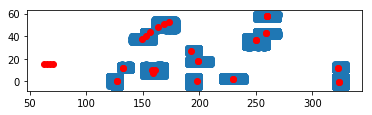

In [17]:
pl.scatter(targetdata['RA'][::100],targetdata['DEC'][::100])
pl.scatter(tiles['RA'],tiles['DEC'],c='r')

pl.axis('scaled')

(-17.985703982525774,
 378.00286567347553,
 -96.941225218371116,
 98.809592429961029)

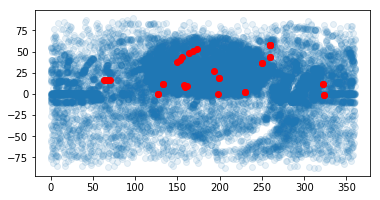

In [19]:
pl.scatter(scnd_targetdata['RA'][::100],scnd_targetdata['DEC'][::100],alpha=0.1)
pl.scatter(tiles['RA'],tiles['DEC'],c='r')

pl.axis('scaled')

## Prepare MTL

Read the target list prepared above and convert it to MTL input to fiberassign.

In [20]:
# Compute MTL

std_mask = 0
for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
    if name in desi_mask.names():
        std_mask |= desi_mask[name]

mtl_path = os.path.join(MTL_DIR,'mtl.fits')
print('MTL path',mtl_path)

reset_mtl = True
if not os.path.exists(mtl_path) or reset_mtl:
    
    if reset_mtl:
        if os.path.exists(mtl_path):
            os.remove(mtl_path)
        
    print('Computing MTL...')
    mtl = desitarget.mtl.make_mtl(targetdata)
    # For tests on the main survey selection we need to include BGS,
    # but for SV we only care about MWS (including only overlaps with BGS)
    
    # only include MWS for SV
    #ismws = mtl['MWS_TARGET'] != 0
    #mtl   = mtl[ismws]
     
    # Because of some hardcoding in desitarget.targets.calc_priority, we have to hack the
    # dark time targets here (assuming no N/S distinction)    
    #for name in ['DARK_MWS_MAIN_BLUE_FAINT',
    #             'DARK_MWS_MAIN_RED_FAINT',
    #             'DARK_MWS_DRACO']:
    #    s = (mtl['DESI_TARGET'] & desi_mask[name]) != 0
    #    mtl['PRIORITY'][s]    = mtl['PRIORITY_INIT'][s]
    #    mtl['NUMOBS_MORE'][s] = mtl['NUMOBS_INIT'][s]

    mtl.meta['EXTNAME'] = 'MTL'
    mtl.write(mtl_path)
    print('Wrote {}'.format(mtl_path))

    # Print some stats
    print('MWS_TARGETS: {}'.format(np.count_nonzero(mtl['SV1_MWS_TARGET']!=0)))
    print('BGS_TARGETS: {}'.format(np.count_nonzero(mtl['SV1_BGS_TARGET']!=0)))
    print('DESI_TARGETS: {}'.format(np.count_nonzero(mtl['SV1_DESI_TARGET']!=0)))
    print('SCND_TARGETS: {}'.format(np.count_nonzero(mtl['SV1_SCND_TARGET']!=0)))

    print('finished computing mtl')    
else:
    mtl = fitsio.read(mtl_path)

MTL path /global/u1/a/apcooper/projects/ssv_plan/runs/ssv_ref/mtl/mtl.fits
Computing MTL...
INFO:mtl.py:119:make_mtl: 20732 of 3886116 targets have priority zero, setting N_obs=0.
Wrote /global/u1/a/apcooper/projects/ssv_plan/runs/ssv_ref/mtl/mtl.fits
MWS_TARGETS: 3865384
BGS_TARGETS: 0
DESI_TARGETS: 3886116
SCND_TARGETS: 67998
finished computing mtl


In [21]:
# HACK
# Add missing target columns to secondary targets with no primary counterpart
new_dt = np.dtype(scnd_targetdata.dtype.descr + [('SV1_DESI_TARGET', targetdata.dtype['SV1_DESI_TARGET'].type), 
                                                 ('SV1_BGS_TARGET', targetdata.dtype['SV1_BGS_TARGET'].type),
                                                 ('SV1_MWS_TARGET', targetdata.dtype['SV1_MWS_TARGET'].type)])

scnd_targetdata_for_mtl = np.zeros(scnd_targetdata.shape, dtype=new_dt)
for n in scnd_targetdata.dtype.names:
    scnd_targetdata_for_mtl[n] = scnd_targetdata[n]

In [ ]:
# Create a second MTL for secondary targets
mtl_scnd_path = os.path.join(MTL_DIR,'mtl_scnd.fits')
print('MTL secondary path',mtl_scnd_path)

reset_mtl_scnd = True
if not os.path.exists(mtl_scnd_path) or reset_mtl_scnd:
    
    if reset_mtl_scnd:
        if os.path.exists(mtl_scnd_path):
            os.remove(mtl_scnd_path)
        
    print('Computing MTL...')
    mtl_scnd = desitarget.mtl.make_mtl(scnd_target_for_mtl)
    mtl_scnd.meta['EXTNAME'] = 'MTL'
    mtl_scnd.write(mtl_scnd_path)
    print('Wrote {}'.format(mtl_scnd_path))

    print('finished computing mtl')    
else:
    mtl_scnd = fitsio.read(mtl_scnd_path)

Sanity-check target numbers (these double-count targets in more than one class).

In [ ]:
for _ in ['MWS_MAIN_SV','MWS_MAIN_SV_FAINT', 'MWS_WD_SV', 'MWS_NEARBY_SV']:
    is_target = (mtl[MWS_TARGET_NAME] & mws_mask[_]) != 0
    n_target  = is_target.sum()
    print('{:20s} {:,}'.format(_,is_target.sum()))
    

In [ ]:
utargetmask, utargetmask_c = np.unique(mtl[MWS_TARGET_NAME],return_counts=True)
for i in range(0,len(utargetmask)):
    print('{:6d} {}'.format(utargetmask_c[i],mws_mask.names(utargetmask[i])))

In [ ]:
utargetmask, utargetmask_c = np.unique(mtl[DESI_TARGET_NAME],return_counts=True)
for i in range(0,len(utargetmask)):
    print('{:6d} {}'.format(utargetmask_c[i],desi_mask.names(utargetmask[i])))

In [ ]:
utargetmask, utargetmask_c = np.unique(mtl[SCND_TARGET_NAME],return_counts=True)
for i in range(0,len(utargetmask)):
    print('{:6d} {}'.format(utargetmask_c[i],scnd_mask.names(utargetmask[i])))

## Run fiberassign

In [ ]:
tile_path = os.path.join(TILES_DIR,'all_mws_sv_tiles.fits')

In [ ]:
ls /project/projectdirs/desi/target/catalogs/dr8c/PR490/main

In [ ]:
resource_paths = {
#     "skies"  : "/project/projectdirs/desi/target/catalogs/dr8/0.31.0/skies/", 
     "skies"  : "/project/projectdirs/desi/www/users/adamyers/forrongpu/0.31.0/skies/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr8/0.31.1/gfas/",
}

resource_names = {
    "skies"   : "skies-dr8-0.31.0.fits", 
    "gfas"    : "cmx-gfas-dr8-0.31.1.fits",
}
    
sky_path     = os.path.join(resource_paths["skies"],resource_names["skies"])
gfa_path     = os.path.join(resource_paths["gfas"], resource_names["gfas"])

Double check some numbers:

In [ ]:
print("Rows in MTL:",len(mtl))
tiles = fitsio.read(tile_path)
print("Tiles to assign:",len(tiles))

In [ ]:
!fba_run -h

In [ ]:
# Set these for main survey or SV
STANDARDS_PER_PETAL  = 20 # SV 20, MAIN 10
SKYS_PER_PETAL       = 80 # SV 80, MAIN 40

for f in glob.glob(os.path.join(OUT_DIR,'*.fits')):
    print('Removing {}'.format(f))
    os.remove(f)
    
cmd = "export DESI_LOGLEVEL=INFO"

# DEBUG options
#cmd =  "export DESI_LOGLEVEL=DEBUG"
#cmd += " DESI_DEBUG_LOCATION=275"
#cmd += " DESI_DEBUG_TILE=1000"

cmd += " PATH=/global/u1/a/apcooper/desi/code/fa_install/bin:$PATH"
cmd += " PYTHONPATH=/global/u1/a/apcooper/desi/code/fa_install/lib/python3.6/site-packages/fiberassign-1.0.3.dev2399-py3.6-linux-x86_64.egg:$PYTHONPATH"
cmd += "; fba_run"
# cmd += " --targets {} {}".format(mtl_path,sky_path)
cmd += " --targets {} {}".format(mtl_path, mtl_scnd_path)
cmd += " --dir {} ".format(OUT_DIR)
cmd += " --footprint {} ".format(tile_path)
cmd += " --standards_per_petal {} ".format(STANDARDS_PER_PETAL)
cmd += " --sky {}".format(sky_path)
cmd += " --sky_per_petal {} ".format(SKYS_PER_PETAL)
cmd += " --write_all_targets "
cmd += " --overwrite "
#cmd += " --tile only_these_tiles.txt" # DEBUG DEBUG DEBUG DEBUG DEBUG
cmd += " > {} ".format(os.path.join(os.path.dirname(OUT_DIR),'fa.log'))

print(cmd)
print('starting fiberassign')
#ecode = os.system(cmd)
ecode = -1
try:
    ecode = subprocess.check_output(cmd,stderr=subprocess.STDOUT,shell=True)
except subprocess.CalledProcessError as e:
    print('FA FAILED')
    print(str(e.output.decode('ascii')))
print('finished fiberassign: {}'.format(ecode))

In [ ]:
!ls $OUT_DIR

## FA postprocessing scripts

In [ ]:
cmd = "export DESI_LOGLEVEL=INFO"
cmd += " PATH=/global/u1/a/apcooper/desi/code/fa_install/bin:$PATH"
cmd += " PYTHONPATH=/global/u1/a/apcooper/desi/code/fa_install/lib/python3.6/site-packages/fiberassign-1.0.3.dev2399-py3.6-linux-x86_64.egg:$PYTHONPATH"
# cmd += "; fba_merge_results  --targets {} {}".format(mtl_path,sky_path)
cmd += "; fba_merge_results  --targets {}".format(mtl_path)
cmd += " --dir {} ".format(OUT_DIR)
cmd += " > {}".format(os.path.join(os.path.dirname(OUT_DIR),'merge_results.log'))

print(cmd)
print('starting merge results')
ecode = os.system(cmd)
print('finished merge results: {}'.format(ecode))

In [ ]:
!ls $OUT_DIR

In [ ]:
outfile_qa = os.path.join(os.path.dirname(OUT_DIR),'qa.json')

cmd = "export DESI_LOGLEVEL=DEBUG"
cmd += " PATH=/global/u1/a/apcooper/desi/code/fa_install/bin:$PATH"
cmd += " PYTHONPATH=/global/u1/a/apcooper/desi/code/fa_install/lib/python3.6/site-packages/fiberassign-1.0.3.dev2399-py3.6-linux-x86_64.egg:$PYTHONPATH"
cmd += "; fba_run_qa"
cmd += " --footprint {} ".format(tile_path)
cmd += " --dir {} ".format(OUT_DIR)
cmd += " --out {} ".format(outfile_qa)
cmd += " > {}".format(os.path.join(os.path.dirname(OUT_DIR),'run_qa.log'))

print(cmd)
print('starting qa ')
ecode = os.system(cmd)
print('finished qa: {}'.format(ecode))

In [ ]:
!ls $OUT_DIR/..

Subsequent cells are not essential.

In [ ]:
outdir_qaplots = os.path.join(os.path.dirname(OUT_DIR),'qa_plots')

for f in glob.glob(os.path.join(outdir_qaplots,'*.*')):
    print('Removing {}'.format(f))
    os.remove(f)

cmd = "export DESI_LOGLEVEL=DEBUG"
cmd += " PATH=PATH=/global/u1/a/apcooper/desi/code/fa_install/bin:$PATH"
cmd += " PYTHONPATH=/global/u1/a/apcooper/desi/code/fa_install/lib/python3.6/site-packages/fiberassign-1.0.3.dev2399-py3.6-linux-x86_64.egg:$PYTHONPATH"
cmd += "; fba_plot_results"
cmd += " --footprint {} ".format(tile_path)
cmd += " --dir {} ".format(OUT_DIR)
cmd += " --out {} ".format(outdir_qaplots)
cmd += " > {}".format(os.path.join(os.path.dirname(OUT_DIR),'run_qaplots.log'))

print(cmd)
print('starting qa plots')
ecode = os.system(cmd)
print('finished qa_plots: {}'.format(ecode))

In [39]:
tile_plots = glob.glob(os.path.join(outdir_qaplots,"fiberassign*.pdf"))
for p in tile_plots:
    cmd = 'pdftoppm -png -singlefile {} {}'.format(p,os.path.join(os.path.dirname(p),
                                                                  os.path.splitext(os.path.basename(p))[0]))
    os.system(cmd)

In [1]:
!fba_plot_results

usage: fba_plot_results [-h] --dir DIR [--prefix PREFIX] [--split] [--out OUT]
                        [--out_prefix OUT_PREFIX] [--out_split]
                        [--petals PETALS] [--real_shapes]
                        [--footprint FOOTPRINT] [--tiles TILES]
                        [--positioners POSITIONERS] [--status STATUS]
                        [--rundate RUNDATE] [--serial]
fba_plot_results: error: the following arguments are required: --dir
